<a href="https://colab.research.google.com/github/tiasmondal/MTP-2021/blob/main/Contrastive_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
#import tensorflow_addons as tfa
import numpy as np
import torchvision
from tensorflow import keras
from tensorflow.keras import layers
import torch
import torch.nn as nn
from sklearn.manifold import TSNE

In [3]:
!nvidia-smi

Tue Sep 21 16:14:09 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:

input1 = torch.randn(4,1)
input2 = torch.randn(4,1)
print(input1)
print(input2)
output = torch.cdist(input1, input2,p=32)
print(output)

tensor([[-0.0225],
        [ 0.9166],
        [ 1.1826],
        [ 0.0620]])
tensor([[-0.0252],
        [-0.8546],
        [-0.1529],
        [-0.3555]])
tensor([[0.0000, 0.8320, 0.1303, 0.3329],
        [0.9418, 1.7712, 1.0694, 1.2720],
        [1.2077, 2.0371, 1.3354, 1.5380],
        [0.0872, 0.9166, 0.2149, 0.4175]])


SIMCLR LOSS

In [4]:
class SimCLR_Loss(nn.Module):
    def __init__(self, batch_size, temperature):
        super(SimCLR_Loss, self).__init__()
        self.batch_size = batch_size
        self.temperature = temperature
        self.mask = self.mask_correlated_samples(batch_size)
        self.criterion = nn.CrossEntropyLoss(reduction="sum")
        self.similarity_f = nn.CosineSimilarity(dim=2)
    

    def mask_correlated_samples(self, batch_size):
        N = 2 * batch_size
        mask = torch.ones((N, N), dtype=bool)
        mask = mask.fill_diagonal_(0)
        for i in range(batch_size):
            mask[i, batch_size + i] = 0
            mask[batch_size + i, i] = 0
        return mask
    def lploss(self, z_i,z_j,p):
      diff=z_i-z_j
      v=torch.pow(diff,p)
      return(torch.sum(v))
    def forward(self, z_i, z_j):
        """
        We do not sample negative examples explicitly.
        Instead, given a positive pair, similar to (Chen et al., 2017), we treat the other 2(N − 1) augmented examples within a minibatch as negative examples.
        """
        N = 2 * self.batch_size #* self.world_size
        #z_i_ = z_i / torch.sqrt(torch.sum(torch.square(z_i),dim = 1, keepdim = True))
        #z_j_ = z_j / torch.sqrt(torch.sum(torch.square(z_j),dim = 1, keepdim = True))
        z = torch.cat((z_i, z_j), dim=0)
        #print(z);    #Print for understanding
        z=z.float(); 
        sim = self.similarity_f(z.unsqueeze(1), z.unsqueeze(0)) / self.temperature   #for cosine similarity
        
        #print(sim);              #Print for understanding
        sim_i_j = torch.diag(sim, self.batch_size)
        sim_j_i = torch.diag(sim, -self.batch_size)
        #print(self.mask)               #Print for understanding
        # We have 2N samples, but with Distributed training every GPU gets N examples too, resulting in: 2xNxN
        positive_samples = torch.cat((sim_i_j, sim_j_i), dim=0).reshape(N, 1)
        #print(positive_samples)         #Print for understanding
        negative_samples = sim[self.mask].reshape(N, -1)
        #print(negative_samples)         #Print for understanding
        #SIMCLR
        labels = torch.from_numpy(np.array([0]*N)).reshape(-1).to(positive_samples.device).long() #.float()
        #print(np.array([1]*N).reshape(-1))    #Print for understanding
        #labels was torch.zeros(N)
        logits = torch.cat((positive_samples, negative_samples), dim=1)
        #print(logits)                        #Print for understanding
        loss = self.criterion(logits, labels)
        loss /= N

        return loss



num_classes = 10
input_shape = (32, 32, 3)

# Load the train and test data splits
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

# Display shapes of train and test datasets
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")
X=SimCLR_Loss(2,1)

X.forward(torch.randn( 2, 2),torch.randn(2, 2))

170508288/170498071 [==============================] - 2s 0us/step
x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


tensor(1.2466)

In [30]:
class SimCLR_LossLp1(nn.Module):
    def __init__(self, batch_size, temperature):
        super(SimCLR_LossLp1, self).__init__()
        self.batch_size = batch_size
        self.temperature = temperature
        self.mask = self.mask_correlated_samples(batch_size)
        self.criterion = nn.CrossEntropyLoss(reduction="sum")
        self.similarity_f = nn.CosineSimilarity(dim=2)
    

    def mask_correlated_samples(self, batch_size):
        N = 2 * batch_size
        mask = torch.ones((N, N), dtype=bool)
        mask = mask.fill_diagonal_(0)
        for i in range(batch_size):
            mask[i, batch_size + i] = 0
            mask[batch_size + i, i] = 0
        return mask
    def lploss(self, z_i,z_j,p):
      diff=z_i-z_j
      v=torch.pow(diff,p)
      return(torch.sum(v))
    def forward(self, z_i, z_j):
        """
        We do not sample negative examples explicitly.
        Instead, given a positive pair, similar to (Chen et al., 2017), we treat the other 2(N − 1) augmented examples within a minibatch as negative examples.
        """
        N = 2 * self.batch_size #* self.world_size
        #z_i_ = z_i / torch.sqrt(torch.sum(torch.square(z_i),dim = 1, keepdim = True))
        #z_j_ = z_j / torch.sqrt(torch.sum(torch.square(z_j),dim = 1, keepdim = True))
        z = torch.cat((z_i, z_j), dim=0)
        #print(z);    #Print for understanding
        z=z.float(); 
        sim = torch.cdist(z.unsqueeze(1), z.unsqueeze(0),p=32)/self.temperature   #for cosine similarity
        sim=sim.reshape(N,N);
        #print(np.shape(z1))
        #sim = self.similarity_f(z.unsqueeze(1), z.unsqueeze(0)) / self.temperature
        #print(np.shape(sim))
        #print(sim);              #Print for understanding
        sim_i_j = torch.diag(sim, self.batch_size)
        sim_j_i = torch.diag(sim, -self.batch_size)
        #print(self.mask)               #Print for understanding
        # We have 2N samples, but with Distributed training every GPU gets N examples too, resulting in: 2xNxN
        positive_samples = torch.cat((sim_i_j, sim_j_i), dim=0).reshape(N, 1)
        #print(positive_samples)         #Print for understanding
        negative_samples = sim[self.mask].reshape(N, -1)
        #print(negative_samples)         #Print for understanding
        #SIMCLR
        labels = torch.from_numpy(np.array([0]*N)).reshape(-1).to(positive_samples.device).long() #.float()
        #print(np.array([1]*N).reshape(-1))    #Print for understanding
        #labels was torch.zeros(N)
        logits = torch.cat((positive_samples, negative_samples), dim=1)
        #print(logits)                        #Print for understanding
        loss = self.criterion(logits, labels)
        loss /= N

        return loss



num_classes = 10
input_shape = (32, 32, 3)

# Load the train and test data splits
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

# Display shapes of train and test datasets
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")
X=SimCLR_Loss(2,1)

X.forward(torch.randn( 2, 2),torch.randn(2, 2))

x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


tensor(1.2126)

Attempting Lp loss [Experiment]

In [6]:
class SimCLR_LossLp(nn.Module):
    def __init__(self, batch_size, temperature,p):
        super(SimCLR_LossLp, self).__init__()
        self.batch_size = batch_size
        self.temperature = temperature
        self.p=p
        self.mask = self.mask_correlated_samples(batch_size)
        self.criterion = nn.CrossEntropyLoss(reduction="sum")
    
    def computelploss(self,x,y):
      return(torch.sum(torch.pow(x-y,self.p))/self.temperature)
    def Lploss(self,z_i,z_j):
      pos=torch.tensor([]).cuda();
      neg=torch.tensor([]).cuda();
      for i in range(0,self.batch_size):
        neg2=torch.tensor([]).cuda();
        for j in range(0,self.batch_size):
          x=self.computelploss(z_i[i],z_j[j]).reshape((1,)).cuda()
          if(i==j):
            pos=torch.cat((pos,x),dim=0)
          else:
            neg2=torch.cat((neg2,x),dim=0)
        neg=torch.cat((neg,neg2),dim=0)
      for i in range(0,self.batch_size):
        neg2=torch.tensor([]).cuda();
        for j in range(0,self.batch_size):
          x=self.computelploss(z_j[i],z_i[j]).reshape((1,)).cuda()
          if(i==j):
            pos=torch.cat((pos,x),dim=0)
          else:
            neg2=torch.cat((neg2,x),dim=0)
        neg=torch.cat((neg,neg2),dim=0)
        
      N = 2*self.batch_size
      neg=neg.reshape((N,-1))
      pos=pos.reshape((N,1))
      
      return(pos,neg)
    

    def mask_correlated_samples(self, batch_size):
        N = 2 * batch_size
        mask = torch.ones((N, N), dtype=bool)
        mask = mask.fill_diagonal_(0)
        for i in range(batch_size):
            mask[i, batch_size + i] = 0
            mask[batch_size + i, i] = 0
        return mask
    
    def forward(self, z_i, z_j):
        """
        We do not sample negative examples explicitly.
        Instead, given a positive pair, similar to (Chen et al., 2017), we treat the other 2(N − 1) augmented examples within a minibatch as negative examples.
        """
        N = 2 * self.batch_size #* self.world_size
        #z_i_ = z_i / torch.sqrt(torch.sum(torch.square(z_i),dim = 1, keepdim = True))
        #z_j_ = z_j / torch.sqrt(torch.sum(torch.square(z_j),dim = 1, keepdim = True))
        z = torch.cat((z_i, z_j), dim=0)
        #print(z);    #Print for understanding
        z=z.float(); 
        #sim = self.similarity_f(z.unsqueeze(1), z.unsqueeze(0)) / self.temperature   #for cosine similarity
        
        #print(sim);              #Print for understanding
        #sim_i_j = torch.diag(sim, self.batch_size)
        #sim_j_i = torch.diag(sim, -self.batch_size)
        #print(self.mask)               #Print for understanding
        # We have 2N samples, but with Distributed training every GPU gets N examples too, resulting in: 2xNxN
        positive_samples,negative_samples = self.Lploss(z_i,z_j)
        #print(positive_samples)         #Print for understanding
        #negative_samples = sim[self.mask].reshape(N, -1)
        #print(negative_samples)         #Print for understanding
        #SIMCLR
        labels = torch.from_numpy(np.array([0]*N)).reshape(-1).to(positive_samples.device).long() #.float()
        #print(np.array([1]*N).reshape(-1))    #Print for understanding
        #labels was torch.zeros(N)
        logits = torch.cat((positive_samples, negative_samples), dim=1)
        #print(logits)                        #Print for understanding
        loss = self.criterion(logits, labels)
        loss /= N

        return loss



num_classes = 10
input_shape = (32, 32, 3)

# Load the train and test data splits
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

# Display shapes of train and test datasets
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")
X=SimCLR_Loss(2,1)

X.forward(torch.randn( 2, 2),torch.randn(2, 2))

x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


tensor(1.7065)

Transform Layer

In [7]:
class TransformsSimCLR:
    """
    A stochastic data augmentation module that transforms any given data example randomly
    resulting in two correlated views of the same example,
    denoted x ̃i and x ̃j, which we consider as a positive pair.
    """

    def __init__(self, size):
        s = 1
        color_jitter = torchvision.transforms.ColorJitter(
            0.8 * s, 0.8 * s, 0.8 * s, 0.2 * s
        )
        self.train_transform = torchvision.transforms.Compose(
            [
                torchvision.transforms.RandomResizedCrop(size=size),
                torchvision.transforms.RandomHorizontalFlip(),  # with 0.5 probability
                torchvision.transforms.RandomApply([color_jitter], p=0.8),
                torchvision.transforms.RandomGrayscale(p=0.2),
                torchvision.transforms.ToTensor(),
            ]
        )

        self.test_transform = torchvision.transforms.Compose(
            [
                torchvision.transforms.Resize(size=size),
                torchvision.transforms.ToTensor(),
            ]
        )

    def __call__(self, x):
        return self.train_transform(x), self.train_transform(x)

Loading dataset

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


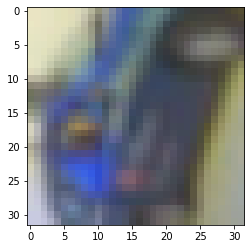

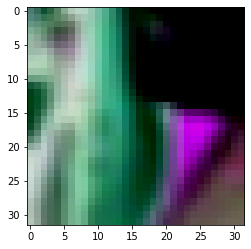

In [8]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

training_data = datasets.CIFAR10(                #Loading CIFAR 10
    root="data",
    train=True,
    download=True,
    transform=TransformsSimCLR((32,32))
)
test_dataset = torchvision.datasets.CIFAR10(root='data',
train=False,
download=True,
transform=TransformsSimCLR((32,32)))


train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)          #Loading train loader

train_loader = torch.utils.data.DataLoader(
        training_data,
        batch_size=64,
        shuffle=True,
        drop_last=True,
        
    )
test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=64,  #Classifier batch size
        shuffle=False,
        drop_last=True,
        
    )

'''train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]'''
cnt=0;

for step, ((x_i, x_j),_) in enumerate(train_loader):
  plt.imshow(x_i[1].T)
  break;
plt.figure()
for step, ((x_i, x_j),_) in enumerate(test_loader):
  plt.imshow(x_i[1].T)
  break;

Resnet Identity Function

In [9]:
def resnet(pretrained = False):
  resnet1=torchvision.models.resnet18(pretrained=pretrained)
  return(resnet1)
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x

SIMCLR Forward Propagation with Projection head

In [10]:
class SimCLR(nn.Module):
    """
    We opt for simplicity and adopt the commonly used ResNet (He et al., 2016) to obtain hi = f(x ̃i) = ResNet(x ̃i) where hi ∈ Rd is the output after the average pooling layer.
    """

    def __init__(self, encoder, projection_dim, n_features):
        super(SimCLR, self).__init__()

        self.encoder = encoder
        self.n_features = n_features

        # Replace the fc layer with an Identity function
        self.encoder.fc = Identity()

        # We use a MLP with one hidden layer to obtain z_i = g(h_i) = W(2)σ(W(1)h_i) where σ is a ReLU non-linearity.
        self.projector = nn.Sequential(
            nn.Linear(self.n_features, self.n_features, bias=False),
            nn.BatchNorm1d(num_features=512),
            nn.ReLU(),
            nn.Linear(self.n_features, projection_dim, bias=False),
            nn.BatchNorm1d(num_features=512)
        )

    def forward(self, x_i, x_j):
        h_i = self.encoder(x_i)
        h_j = self.encoder(x_j)

        z_i = self.projector(h_i)
        z_j = self.projector(h_j)
        return h_i, h_j, z_i, z_j

SIMCLR Training 

In [11]:
def train(train_loader, model, criterion, optimizer):
    loss_epoch = 0
    for step, ((x_i, x_j), _) in enumerate(train_loader):
        optimizer.zero_grad()
        x_i = x_i.cuda(non_blocking=True)
        x_j = x_j.cuda(non_blocking=True)

        # positive pair, with encoding
        h_i, h_j, z_i, z_j = model(x_i, x_j)

        loss = criterion(z_i, z_j)
        loss.backward()

        optimizer.step()

        loss_epoch += loss.item()
    return loss_epoch


In [12]:

import os
os.chdir("drive/MyDrive")


In [13]:
def save_model(simclr_model,epoch):
  PATH='modelLp'
  state = {
    'epoch': epoch,
    'state_dict': simclr_model.state_dict(),
    'optimizer': optimizer.state_dict(),
  }
  torch.save(state, PATH)

Main() for pretraining Resnet

In [31]:
from torchsummary import summary
encoder = resnet(pretrained=False)
n_features = encoder.fc.in_features  # get dimensions of fc layer
projection_dim=512       #change projection dimension here.
simclr_model = SimCLR(encoder, projection_dim, n_features).cuda()  #first time
#state = torch.load('model')
#simclr_model.load_state_dict(state['state_dict'])
optimizer = torch.optim.Adam(simclr_model.parameters(), lr=3e-4)
#optimizer.load_state_dict(state['optimizer'])

scheduler = None

batch_size=64   #change batch size here
temperature= 0.5   #change temperature here
#criterion = SimCLR_Loss(batch_size, temperature)         #cosine similarity simCLR loss
criterion = SimCLR_LossLp1(batch_size,temperature)
num_epochs = 2
#summary(simclr_model,[(3,32,32),(3,32,32)])
#exit()
for epoch in range(1, num_epochs):
  lr = optimizer.param_groups[0]["lr"]
  loss_epoch = train(train_loader, simclr_model, criterion, optimizer)
  print(epoch)

save_model(simclr_model,num_epochs)   

'''if args.nr == 0 and epoch % 10 == 0:
save_model(args, model, optimizer) ''' #saving model


1


'if args.nr == 0 and epoch % 10 == 0:\nsave_model(args, model, optimizer) '

In [26]:
x=torch.tensor([3])


x=torch.cat((x,torch.tensor([3])),dim=0)
#x=torch.cat((x,torch.tensor([4])),dim=0)
#x=torch.cat((x,torch.tensor([1,2,3])),dim=0)
x

tensor([3, 3])

TSNE Plot for original and encoded data

(9984, 2)
(9984,)
(9984,)
(1, 2)


<Figure size 432x288 with 0 Axes>

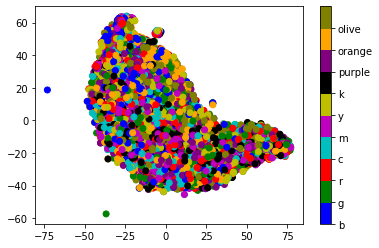

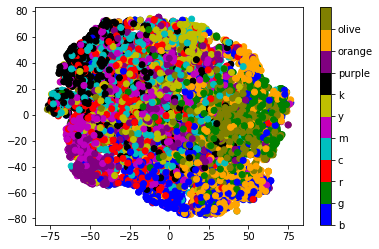

<Figure size 432x288 with 0 Axes>

In [ ]:
#original data
import matplotlib
data=[];
label=[]
data_enc=[]
cnt=0
encoder = resnet(pretrained=False)
n_features = encoder.fc.in_features  # get dimensions of fc layer
projection_dim=512       #change projection dimension here.
simclr_model = SimCLR(encoder, projection_dim, n_features).cuda()  #first time
state = torch.load('model')
simclr_model.load_state_dict(state['state_dict'])
optimizer = torch.optim.Adam(simclr_model.parameters(), lr=3e-4)
optimizer.load_state_dict(state['optimizer'])
for step, ((x_i,_),gt_i) in enumerate(test_loader):
  
  for sp1,x in enumerate(x_i):
    x=np.array(x).reshape((32*32*3));
    data.append(np.array(x))
  x_i = x_i.cuda(non_blocking=True)
  h_i,_,z_i,_=simclr_model(x_i,x_i)
  h_i=h_i.cpu().detach().numpy()
  for sp1,x in enumerate(h_i):
    data_enc.append(x)
  for sp1,x in enumerate(gt_i):
    label.append(x)
  cnt+=64;
  

data=np.array(data);
label=np.array(label)
md=TSNE(random_state=0)
data=md.fit_transform(data)
data_enc=md.fit_transform(data_enc)
print(np.shape(data))
print(np.shape(label))
import seaborn as sns
print(np.shape(data[:,0]))
print(np.shape(data[:1]))
colors=['b','g','r','c','m','y','k','purple','orange','olive']
plt.scatter(x=data[:,0],y=data[:,1],c=label,cmap=matplotlib.colors.ListedColormap(colors))
cb = plt.colorbar()
loc = np.arange(0,max(label),max(label)/float(len(colors)))
cb.set_ticks(loc)
cb.set_ticklabels(colors)
plt.savefig('original2.png', bbox_inches='tight')
plt.figure()

plt.scatter(x=data_enc[:,0],y=data_enc[:,1],c=label,cmap=matplotlib.colors.ListedColormap(colors))
cb = plt.colorbar()
loc = np.arange(0,max(label),max(label)/float(len(colors)))
cb.set_ticks(loc)
cb.set_ticklabels(colors)
plt.savefig('encoded2.png', bbox_inches='tight')
plt.figure()

In [ ]:
X = np.array([[0, 0, 0], [0, 1, 1], [1, 0, 1], [1, 1, 1]])
model = TSNE(n_components=2, random_state=0)
model.fit_transform(X) 

Logistic Regression

In [ ]:
class LogisticRegression(nn.Module):
    def __init__(self, n_features, n_classes):
        super(LogisticRegression, self).__init__()

        self.model = nn.Linear(n_features, n_classes)

    def forward(self, x):
        return self.model(x)

Linear Classifier

In [ ]:
def inference(loader, simclr_model, device):
    feature_vector = []
    labels_vector = []
    for step, ((x, _),y) in enumerate(loader):
        
        x = x.to(device)
        
        # get encoding
        with torch.no_grad():
            h, _, z, _ = simclr_model(x, x)

        h = h.detach()

        feature_vector.extend(h.cpu().detach().numpy())
        labels_vector.extend(y.numpy())

        if step % 20 == 0:
            print(f"Step [{step}/{len(loader)}]\t Computing features...")
            #break

    feature_vector = np.array(feature_vector)
    labels_vector = np.array(labels_vector)
    print("Features shape {}".format(feature_vector.shape))
    return feature_vector, labels_vector


def get_features(simclr_model, train_loader, test_loader, device):
    train_X, train_y = inference(train_loader, simclr_model, device)
    test_X, test_y = inference(test_loader, simclr_model, device)
    return train_X, train_y, test_X, test_y


def create_data_loaders_from_arrays(X_train, y_train, X_test, y_test, batch_size):
    train = torch.utils.data.TensorDataset(
        torch.from_numpy(X_train), torch.from_numpy(y_train)
    )
    train_loader = torch.utils.data.DataLoader(
        train, batch_size=batch_size, shuffle=False
    )

    test = torch.utils.data.TensorDataset(
        torch.from_numpy(X_test), torch.from_numpy(y_test)
    )
    test_loader = torch.utils.data.DataLoader(
        test, batch_size=batch_size, shuffle=False
    )
    return train_loader, test_loader

device = 'cuda:0'
def train1(loader, simclr_model, model, criterion, optimizer):
    loss_epoch = 0
    accuracy_epoch = 0
    for step, (x, y) in enumerate(loader):
        optimizer.zero_grad()

        x = x.cuda()
        y = y.cuda()

        output = model(x)

        #y=torch.argmax(y,dim=1)
       
        #print(output)
        #print(y)
        loss = criterion(output, y)

        predicted = output.argmax(1)
        acc = (predicted == y).sum().item() / y.size(0)
        accuracy_epoch += acc

        loss.backward()
        optimizer.step()

        loss_epoch += loss.item()
        # if step % 100 == 0:
        #     print(
        #         f"Step [{step}/{len(loader)}]\t Loss: {loss.item()}\t Accuracy: {acc}"
        #     )

    return loss_epoch, accuracy_epoch


def test(loader, simclr_model, model, criterion, optimizer):
    loss_epoch = 0
    accuracy_epoch = 0
    model.eval()
    for step, (x,y) in enumerate(loader):
        model.zero_grad()

        x = x.to(device)
        y = y.to(device)
        y=y.long()
        output = model(x)
        loss = criterion(output, y)

        predicted = output.argmax(1)
        acc = (predicted == y).sum().item() / y.size(0)
        accuracy_epoch += acc

        loss_epoch += loss.item()

    return loss_epoch, accuracy_epoch

n_classes = 10  # CIFAR-10 / STL-10
state = torch.load('model')
simclr_model.load_state_dict(state['state_dict'])
simclr_model.eval();
model = LogisticRegression(simclr_model.n_features, n_classes)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
criterion = torch.nn.CrossEntropyLoss()
(train_X, train_y, test_X, test_y) = get_features(
        simclr_model, train_loader, test_loader, device
    )
#print(train_y);
#exit(0)
arr_train_loader, arr_test_loader = create_data_loaders_from_arrays(
        train_X, train_y, test_X, test_y, batch_size
    )
'''for step, (x, y) in enumerate(arr_train_loader):
  print(np.shape(x))
  print(np.shape(y));'''
#exit(0)
logistic_epochs=10;
for epoch in range(logistic_epochs):
    loss_epoch, accuracy_epoch = train1(
        arr_train_loader, simclr_model, model, criterion, optimizer
        )
print(
            f"Epoch [{epoch}/{logistic_epochs}]\t Loss: {loss_epoch / len(arr_train_loader)}\t Accuracy: {accuracy_epoch / len(arr_train_loader)}"
)

    # final testing
loss_epoch, accuracy_epoch = test(
        arr_test_loader, simclr_model, model, criterion, optimizer
    )
print(
   f"[FINAL]\t Loss: {loss_epoch / len(arr_test_loader)}\t Accuracy: {accuracy_epoch / len(arr_test_loader)}"
    )

Step [0/781]	 Computing features...
Step [20/781]	 Computing features...
Step [40/781]	 Computing features...
Step [60/781]	 Computing features...
Step [80/781]	 Computing features...
Step [100/781]	 Computing features...
Step [120/781]	 Computing features...
Step [140/781]	 Computing features...
Step [160/781]	 Computing features...
Step [180/781]	 Computing features...
Step [200/781]	 Computing features...
Step [220/781]	 Computing features...
Step [240/781]	 Computing features...
Step [260/781]	 Computing features...
Step [280/781]	 Computing features...
Step [300/781]	 Computing features...
Step [320/781]	 Computing features...
Step [340/781]	 Computing features...
Step [360/781]	 Computing features...
Step [380/781]	 Computing features...
Step [400/781]	 Computing features...
Step [420/781]	 Computing features...
Step [440/781]	 Computing features...
Step [460/781]	 Computing features...
Step [480/781]	 Computing features...
Step [500/781]	 Computing features...
Step [520/781]	 Co

In [ ]:
x=[[0,1,0,0],[1,0,0,0]]
x=torch.Tensor(x);
x=torch.argmax(x,dim=1)
print(x)
